In [1]:
from    tqdm.notebook       import  tqdm, trange

import  numpy               as      np

from    scipy.interpolate   import  RegularGridInterpolator
from    scipy.ndimage       import  map_coordinates

import  matplotlib.pyplot   as      plt
from    IPython             import  display

from    kinetic.utils        import  *
from    kinetic.distribution import  *
from    kinetic.collision_kernel import  *

### Generate the grid

In [2]:
# Time
DELTA_T:    float       = 0.01
MIN_T:      float       = 0.0
MAX_T:      float       = 1.0
NUM_T:      int         = int(1 + (MAX_T - MIN_T + 0.1*DELTA_T) / DELTA_T)
ARR_T:      np.ndarray  = np.linspace(MIN_T, MAX_T, NUM_T)

# Dimension and resolution
DIMENSION:  int         = 1
NUM_X:      int         = 40
NUM_V:      int         = 20

# Location
MAX_X:      float       = 5.0
MAX_V:      float       = 6.0
DELTA_X:    float       = (2*MAX_X) / (NUM_X-1)
_ARR_X_1D:  np.ndarray  = np.linspace(-MAX_X, MAX_X, NUM_X)
_X_EXTENT = [-MAX_X, MAX_X, MAX_X, -MAX_X]

# Velocity
MAX_V:      float       = 6.0
DELTA_V:    float       = (2*MAX_V) / (NUM_V-1)
_ARR_V_1D:  np.ndarray  = np.linspace(-MAX_V, MAX_V, NUM_V)
_V_EXTENT = [-MAX_V, MAX_V, MAX_V, -MAX_V]

# Grids
GRID_X_ONLY:    np.ndarray = space_grid(   DIMENSION, NUM_X, MAX_X, where_closed='both')
GRID_V_ONLY:    np.ndarray = velocity_grid(DIMENSION, NUM_V, MAX_V, where_closed='both')
GRID_XV:        np.ndarray = \
    np.stack(
        np.meshgrid(
            *(_ARR_X_1D for _ in range(DIMENSION)),
            *(_ARR_V_1D for _ in range(DIMENSION)),
            indexing='ij',
        ),
        axis=-1,
    )
GRID_X = GRID_X_ONLY.reshape(*repeat(NUM_X, DIMENSION), *ones(DIMENSION), DIMENSION)
GRID_V = GRID_V_ONLY.reshape(*ones(DIMENSION), *repeat(NUM_V, DIMENSION), DIMENSION)
print(f"{GRID_X_ONLY.shape=}, {GRID_V_ONLY.shape=}")
print(f"{GRID_X.shape=}, {GRID_V.shape=}, {GRID_XV.shape=}")

# VHS model
VHS_ALPHA:      float   = 0
VHS_COEFF:      float   = default_vhs_coeff_test(DIMENSION) * 10

# Metric
METRIC_ORDER:   float   = np.inf
def metric(pred: np.ndarray, target: np.ndarray) -> float:
    numer = np.linalg.norm((pred - target).flatten(), ord=METRIC_ORDER)
    denom = np.linalg.norm(target.flatten(), ord=METRIC_ORDER) + 1e-32
    return float(numer / denom)


# Problem type
PROBLEM_TYPE:   str = 'bkw'
PROBLEM_TYPE = PROBLEM_TYPE.lower()

## BKW solution
BKW_COEFF_EXT:  float = None if DIMENSION not in [2,3] else default_bkw_coeff_ext_test(DIMENSION)

## Maxwellian distribution
MAXWELLIAN_MEAN_DENSITY:        float       = 1.0
MAXWELLIAN_MEAN_VELOCITY:       np.ndarray  = np.zeros(DIMENSION)
MAXWELLIAN_MEAN_TEMPERATURE:    float       = 1.0

## Bimodal distribution
BIMODAL_MODE1_MEAN_DENSITY:     float       = 0.5
BIMODAL_MODE1_MEAN_VELOCITY:    np.ndarray  = np.array([MAX_V/6, *zeros(DIMENSION-1)])
BIMODAL_MODE1_MEAN_TEMPERATURE: float       = 0.5

GRID_X_ONLY.shape=(40, 1), GRID_V_ONLY.shape=(20, 1)
GRID_X.shape=(40, 1, 1), GRID_V.shape=(1, 20, 1), GRID_XV.shape=(40, 20, 2)


In [3]:
# Initialize physical quantities
mean_density:       np.ndarray  = 1 + np.exp(-0.5 * (GRID_X_ONLY[..., 0]**2))
mean_velocity:      np.ndarray  = np.zeros((*mean_density.shape, DIMENSION))
mean_temperature:   np.ndarray  = 1 + np.zeros_like(mean_density)

assert mean_density.ndim==DIMENSION
assert mean_temperature.ndim==DIMENSION

mean_density = mean_density.reshape(1, *mean_density.shape, 1)
mean_velocity = mean_velocity.reshape(1, *mean_velocity.shape)
mean_temperature = mean_temperature.reshape(1, *mean_temperature.shape, 1)

print(f"{mean_density.shape     =}")
print(f"{mean_velocity.shape    =}")
print(f"{mean_temperature.shape =}")

mean_density.shape     =(1, 40, 1)
mean_velocity.shape    =(1, 40, 1)
mean_temperature.shape =(1, 40, 1)


## Multidimensional BGK equation

1. Trace backward with the approximation by interpolation.
2. Compute the collision term using the interpolation, and update the distribution function.

(1, 40, 20)
(1, 40, 20)


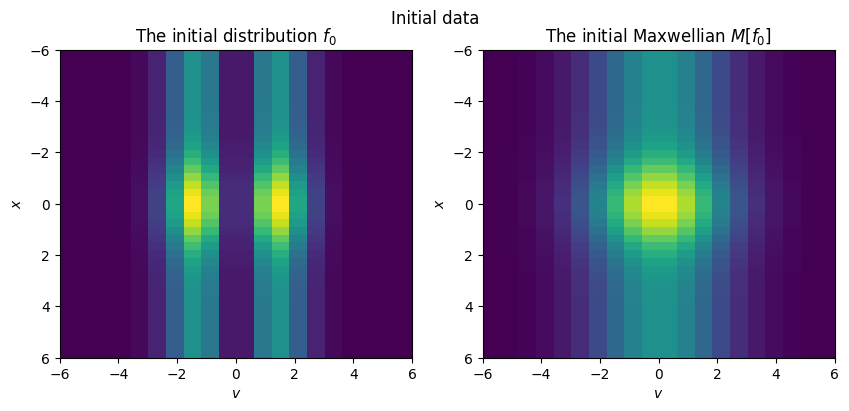

In [4]:
f_init: np.ndarray = maxwellian_inhomogeneous(
                GRID_XV,
                mean_density,
                mean_velocity,
                mean_temperature
            ) * np.sum(GRID_V**2, axis=-1) / 150
arr_f: np.ndarray = f_init
print(arr_f.shape)
equi_init: np.ndarray = maxwellian_inhomogeneous(
                GRID_XV,
                *compute_moments_inhomogeneous(arr_f, GRID_V_ONLY, eps=0.0),
                eps = 0.0,
            )
print(equi_init.shape)

##################################################
##################################################

fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle(f"Initial data")
if DIMENSION==1:
    # Initial distribution
    axes[0].set_title(f"The initial distribution $f_0$")
    axes[0].imshow(f_init[0], extent=_V_EXTENT, aspect='auto')
    axes[0].set_xlabel("$v$")
    axes[0].set_ylabel("$x$")
    # Initial Maxwellian
    axes[1].set_title(f"The initial Maxwellian $M[f_0]$")
    axes[1].imshow(equi_init[0], extent=_V_EXTENT, aspect='auto')
    axes[1].set_xlabel("$v$")
    axes[1].set_ylabel("$x$")
elif DIMENSION==2:
    # Initial distribution
    axes[0].set_title(f"The initial distribution $f_0$ integrated w.r.t. $v$")
    axes[0].imshow(f_init[0].sum(axis=(-3,-2)), extent=_V_EXTENT, aspect='auto')
    axes[0].set_xlabel("$x_1$")
    axes[0].set_ylabel("$x_2$")
    # Initial Maxwellian
    axes[1].set_title(f"The initial Maxwellian $M[f_0]$ integrated w.r.t. $v$")
    axes[1].imshow(equi_init[0].sum(axis=(-2,-1)), extent=_V_EXTENT, aspect='auto')
    axes[1].set_xlabel("$x_1$")
    axes[1].set_ylabel("$x_2$")
plt.show()

In [5]:
# Define the collision operator 1
# def collision(__PLACEHOLDER__t_curr: float, f_curr: np.ndarray) -> np.ndarray:
#     moments = compute_moments_inhomogeneous(f_curr, GRID_V_ONLY)
#     # print([x.shape for x in moments])
#     equi_curr = maxwellian_inhomogeneous(GRID_XV, *moments)
#     return (equi_curr - f_curr) / relaxation_time


# Define the collision operator 2
v_indices = velocity_index_tensor(DIMENSION, NUM_V, keepdims=False)
_dvm_scale = (2**DIMENSION) * (DELTA_V**DIMENSION)
_pairs = compute_conservative_pairs(DIMENSION, NUM_V)

def collision(__PLACEHOLDER__t_curr: float, f_curr: np.ndarray) -> np.ndarray:
    ret = np.zeros(f_curr.shape)
    for vi in tqdm(v_indices):
        ret_i: np.ndarray   = 0.0
        for vj in v_indices:
            ret_ij: float   = 0.0
            N_ij:   int     = 0
            for vs in v_indices:
                for vt in v_indices:
                    # Check if the current pair of velocities is admissible
                    if not np.all(vi+vj == vs+vt):
                        continue
                    if not float(
                            ( np.sum(vi**2) + np.sum(vj**2) ) - \
                            ( np.sum(vs**2) + np.sum(vt**2) )
                        ) == 0:
                        continue
                    
                    # Update `N_ij` and `ret_ij` WITHOUT multiplying `_dvm_scale / N_ij`
                    _rel_speed = np.linalg.norm(GRID_V_ONLY[tuple(vj)]-GRID_V_ONLY[tuple(vi)])
                    ret_ij  += VHS_COEFF * \
                        (_rel_speed**VHS_ALPHA) * (
                        +f_curr[..., tuple(vs)] * f_curr[..., tuple(vt)] \
                        -f_curr[..., tuple(vi)] * f_curr[..., tuple(vj)]
                    )
                    N_ij    += 1
            
            # Final update of `ret_ij` and `ret_i`
            if N_ij != 0:
                ret_ij = ret_ij * (_dvm_scale/N_ij)
            else:
                ret_ij = 0
            ret_i += ret_ij
        ret[..., tuple(vi)] = ret_i
    
    return ret


# Configurations for the semi-Lagrangian scheme for the BGK equation
query: np.ndarray = GRID_XV.copy()
# Modify the x-coordinates
query[..., :DIMENSION] -= DELTA_T * query[..., DIMENSION:]
query[..., :DIMENSION] = (query[..., :DIMENSION] + MAX_X) % (2*MAX_X) - MAX_X
relaxation_time:    float   = 0.5

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

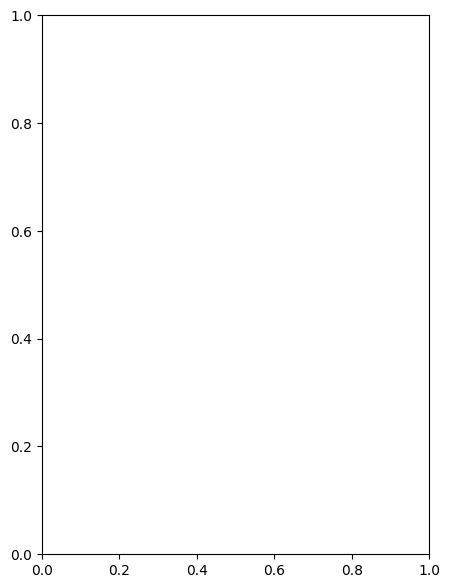

In [6]:
arr_distribution    = []
arr_mean_density    = []
arr_mean_velocity   = []
arr_total_energy    = []
arr_entropy         = []
arr_rel_error       = []

t_curr: float = 0.0

fig, ax = plt.subplots(1, 1, figsize=(5,7))
for idx in trange(NUM_T):
    arr_distribution.append(arr_f)
    _density, _velocity, __ = compute_moments_inhomogeneous(arr_f, GRID_V_ONLY)
    _energy = compute_energy_inhomogeneous(arr_f, GRID_V_ONLY, dx=DELTA_X**DIMENSION)
    arr_mean_density.append(_density)
    arr_mean_velocity.append(_velocity)
    arr_total_energy.append(_energy)
    
    if False:
        if DIMENSION == 1:
            plt.imshow(arr_f, aspect='auto')
            plt.title(f"Distribution function ($t={t_curr:.2f}, t_f={MAX_T:.2f}$)")
            plt.xlabel("$v$")
            plt.ylabel("$x$")
        elif DIMENSION == 2:
            plt.imshow(arr_f[0].sum(axis=(0,1)), extent=_X_EXTENT, aspect='auto')
            plt.title(f"Distribution function integrated w.r.t. $x$ ($t={t_curr:.2f}, t_f={MAX_T:.2f}$)")
            plt.xlabel("$x_1$")
            plt.ylabel("$x_2$")
        plt.colorbar()
        plt.show()
    # Phase 1. Advection
    ## Generate the interpolator for each time step
    interp = RegularGridInterpolator(
        (
            *(_ARR_X_1D for _ in range(DIMENSION)),
            *(_ARR_V_1D for _ in range(DIMENSION)),
        ),
        arr_f[0],
        method = 'linear',
        # bounds_error = False, fill_value = 0.0,
    )
    arr_f: np.ndarray = interp(query)[None, ...]
    
    # Phase 2. Collision
    arr_f = one_step_RK2_Ralston(t_curr, arr_f, DELTA_T, collision)
    
    # Update the arguments
    t_curr += DELTA_T

    
arr_distribution        = np.stack(arr_distribution, axis=1)
arr_mean_density        = np.stack(arr_mean_density, axis=1)
arr_mean_velocity       = np.stack(arr_mean_velocity, axis=1)
arr_total_energy        = np.stack(arr_total_energy, axis=1)
# arr_entropy             = np.stack(arr_entropy, axis=1)
# arr_rel_error           = np.stack(arr_rel_error, axis=1)

In [7]:
print(f"{arr_mean_density.shape =}")
print(f"{arr_mean_velocity.shape=}")
print(f"{arr_total_energy.shape =}")

arr_mean_density.shape =(1, 101, 40, 1)
arr_mean_velocity.shape=(1, 101, 40, 1)
arr_total_energy.shape =(1, 101, 1)


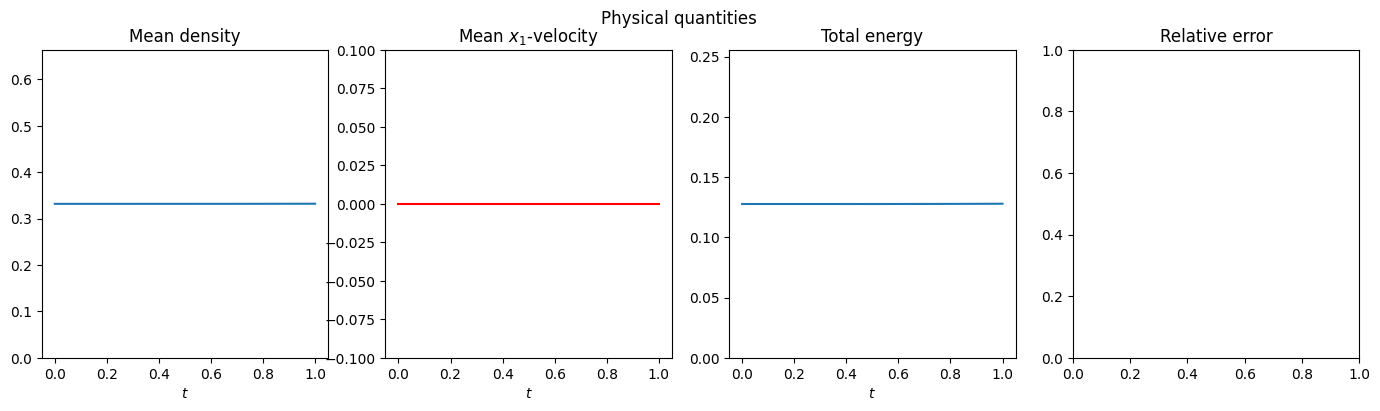

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))
# for idx, t_curr in enumerate(arr_t):
fig.suptitle(f"Physical quantities")

axes[0].set_title(f"Mean density")
_mean_density = np.sum(arr_mean_density,  axis=tuple(range(2, 2+DIMENSION))).flatten()
axes[0].plot(ARR_T, _mean_density)
axes[0].set_ylim(0, 2*_mean_density.max())
axes[0].set_xlabel("$t$")

axes[1].set_title(f"Mean $x_1$-velocity")
_mean_velocity = np.sum(arr_mean_velocity, axis=tuple(range(2, 2+DIMENSION)))[0]
for cnt, style in enumerate(['r-', 'g-', 'b-'][:DIMENSION]):
    axes[1].plot(ARR_T, _mean_velocity[..., cnt], style)
axes[1].set_ylim(_mean_velocity.min() - 0.1, _mean_velocity.max() + 0.1)
axes[1].set_xlabel("$t$")

axes[2].set_title(f"Total energy")
_total_energy = arr_total_energy[0]
axes[2].plot(ARR_T, _total_energy)
axes[2].set_ylim(0, 2*arr_total_energy.max())
axes[2].set_xlabel("$t$")

axes[3].set_title(f"Relative error")
# axes[3].plot(ARR_T, arr_rel_error[0])
# axes[3].set_ylim(0, 1)
# axes[3].set_xlabel("$t$")

plt.show()

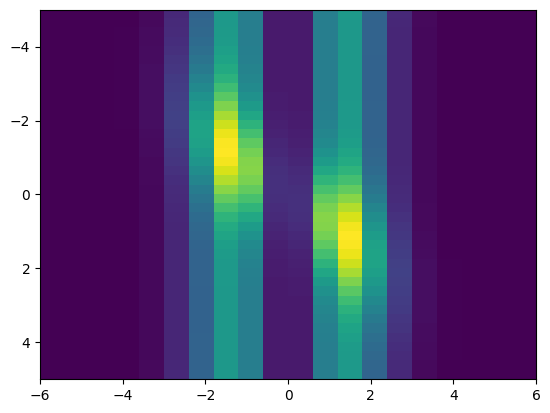

In [15]:
plt.imshow(arr_distribution[0, 80], aspect='auto', extent=[-MAX_V, MAX_V, MAX_X, -MAX_X])
plt.show()

In [ ]:
if False:
    np.savez(
        file = f"DVM_{dim}D__BGK_res{len(_grid_x_1d)}_L{max_v:.2e}_T{max_t}_dt{delta_t:.2e}",
        
        metric_order            = None,
        elapsed_time            = None,
        
        min_t                   = 0.0,
        max_t                   = max_t,
        delta_t                 = delta_t,
        
        arr_distribution        = arr_distribution,
        arr_mean_density        = arr_mean_density,
        arr_mean_velocity       = arr_mean_velocity,
        arr_mean_temperature    = arr_mean_temperature,
        arr_rel_error           = None,
    )

In [ ]:
0 ** -1

End of file